In [2]:
import os
import codecs
import json
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
import matplotlib.pyplot as plt

data_directory = os.path.join('/home/kist/yelp_13')
intermediate_directory = os.path.join(data_directory, 'intermediate')

In [8]:
df = pd.read_csv(os.path.join(intermediate_directory, 'useful.csv'))
luseful = np.log(df['useful'] + 1)

print(type(luseful))
print(df.shape)
print(df[:10])

<class 'pandas.core.series.Series'>
(1002, 2)
   Unnamed: 0  useful
0           0       6
1           1       3
2           2       3
3           3       1
4           4       1
5           5       2
6           6       0
7           7       0
8           8       4
9           9      11


In [3]:
# Gensim's Doc2Vec class creates vector representations for entire documents
# The input object is an iterator of LineSentence objects
# The default dm=1 refers to the distributed memory algorithm
# The algorithm runs through sentences twice: (1) build the vocab, 
# (2) learn a vector representation for each word and for each label (sentence)
# Better results can be achieved by iterating over the data several times

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from pprintpp import pprint

doc2vec_filepath = os.path.join(intermediate_directory, 'doc2vec_model')
doc2vec = Doc2Vec.load(doc2vec_filepath)


# for idx, doctag in sorted(doc2vec.docvecs.doctags.items(), key=lambda x: x[1].offset):
#     print(idx, doctag)


Review_0 Doctag(offset=0, word_count=26, doc_count=1)
Review_1 Doctag(offset=1, word_count=53, doc_count=1)
Review_2 Doctag(offset=2, word_count=44, doc_count=1)
Review_3 Doctag(offset=3, word_count=33, doc_count=1)
Review_4 Doctag(offset=4, word_count=46, doc_count=1)
Review_5 Doctag(offset=5, word_count=56, doc_count=1)
Review_6 Doctag(offset=6, word_count=106, doc_count=1)
Review_7 Doctag(offset=7, word_count=11, doc_count=1)
Review_8 Doctag(offset=8, word_count=82, doc_count=1)
Review_9 Doctag(offset=9, word_count=26, doc_count=1)
Review_10 Doctag(offset=10, word_count=40, doc_count=1)
Review_11 Doctag(offset=11, word_count=43, doc_count=1)
Review_12 Doctag(offset=12, word_count=13, doc_count=1)
Review_13 Doctag(offset=13, word_count=35, doc_count=1)
Review_14 Doctag(offset=14, word_count=29, doc_count=1)
Review_15 Doctag(offset=15, word_count=254, doc_count=1)
Review_16 Doctag(offset=16, word_count=6, doc_count=1)
Review_17 Doctag(offset=17, word_count=80, doc_count=1)
Review_18 D

In [4]:
print(u'{:,} terms in the word2vec vocabulary.'.format(len(doc2vec.wv.vocab)))

138 terms in the word2vec vocabulary.


In [5]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
from collections import defaultdict
from tabulate import tabulate

In [6]:

def cv_rmse(model, X, y, cv=5, scoring='neg_mean_squared_error'):
    
    """ Compute an overall RMSE across all folds of cross validation"""
    
    return np.sqrt(np.mean(np.multiply(cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'), -1)))
    
def RMSE(y_true, y_pred):
    
    """ Root Mean Squared Error"""
    
    return np.sqrt(np.mean((y_true - y_pred)**2))

def RMSLE(y_true, y_pred):
    
    """ Root Mean Squared Logarithmic Error"""
    
    return np.sqrt(np.mean(((np.log(y_true + 1) - np.log(y_pred + 1))**2)))

In [7]:
lr_d2v = Pipeline([("lr", LinearRegression())])
ridge_d2v = Pipeline([("ridge", Ridge(alpha=1))])
gbr_d2v = Pipeline([("gbr", GradientBoostingRegressor(n_estimators=100))])
rfr_d2v = Pipeline([("rfr", RandomForestRegressor(n_estimators=100))])
xgb_d2v = Pipeline([("xgb", XGBRegressor(n_estimators=100))])

# print(luseful)
# print(luseful.shape)
# if len(luseful.shape) == 0:
#     print(l)


In [17]:
d2v_models = [("lr_d2v", lr_d2v), ("ridge_d2v", ridge_d2v), ("gbr_d2v", gbr_d2v), ("rfr_d2v", rfr_d2v), ("xgb_d2v", xgb_d2v)]
# d2v_models = [("lr_d2v", lr_d2v), ("ridge_d2v", ridge_d2v)]

d2v_rmse = [(name, model) for name, model in d2v_models]
# for name, model in d2v_models:
#     print(name)
#     print(model)
    
# print(type(doc2vec.docvecs[0]))
# print(doc2vec.docvecs.doctag_syn0)
# print(type(np.array(doc2vec.docvecs)))

# print(len(luseful))

# print(d2v_rmse)
# print(cv_rmse("lr", np.array(doc2vec.docvecs), luseful, cv=5))


d2v_rmse = [(name, cv_rmse(model, doc2vec.docvecs.vectors_docs, luseful, cv=5)) 
              for name, model in d2v_models]

In [18]:
print (tabulate(sorted(d2v_rmse, key=lambda x:x[1]), floatfmt=".4f", headers=("model", "RMSE_5cv")))

model        RMSE_5cv
---------  ----------
rfr_d2v        0.7632
ridge_d2v      0.7646
xgb_d2v        0.7768
gbr_d2v        0.7832
lr_d2v         0.7994


In [19]:
def benchmark(model, X, y, n):
    ss = ShuffleSplit(n_splits=5, test_size = 1 - n, random_state=0)
    scores = []
    for train, test in ss.split(X,y):
        scores.append(RMSE(y[test], model.fit(X[train],y[train]).predict(X[test])))
    return np.mean(scores)

In [20]:
train_sizes = [0.3, 0.5, 0.7]
table = []
import sys
for name, model in d2v_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'RMSE': benchmark(model, doc2vec.docvecs.vectors_docs, luseful, n),
                      'train_size': n})
df = pd.DataFrame(table)

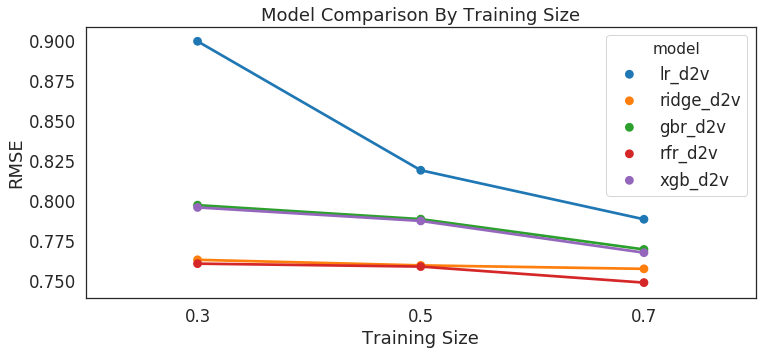

In [21]:
plt.figure(figsize=(12,5))
fig = sns.pointplot(x='train_size', y='RMSE', hue='model',
                   data=df)
sns.set_context('notebook', font_scale=1.5)
fig.set(ylabel='RMSE')
fig.set(xlabel='Training Size')
fig.set(title='Model Comparison By Training Size')
plt.show()